In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from BabelViscoFDTD.tools.RayleighAndBHTE import ForwardSimple, InitCuda, InitOpenCL , GenerateFocusTx
from pprint import pprint
from scipy.io import loadmat
from sys import platform
from time import time
import pyvista as pv

loaded Metal <CDLL '/Users/spichardo/.edm/envs/MORPHEUS36/lib/python3.6/site-packages/BabelViscoFDTD/tools/libRayleighMetal.dylib', handle 7fdae5520f90 at 0x7fdb7875d240>


# GPU-accelerated Rayleigh integral
In this simple example, we will cover the basics how to use the auxiliary tool to calculate Rayleigh integral in homogenous medium

Rayleigh integral is useful to calculate back and forth from a transducer to proxmity to a bone strcuture, saving computing time given Rayleigh is hyperparallel

`ForwardSimple` is the main function, which selects automatically CUDA (Windows and Linux) or OpenCL (MacOS)

**Please note this function depends on pycuda (Windows and Linux) and pyopencl (MacOS), and that MSVC X64 command lines tools are in path. You can ensure this by starting the notebook (jupyter notebook) from a command prompt from Visual Studio x64 command line**

For support to pyvista embedded widget, use only **jupyter notebook** as pyvista has still some limitations with jupyter-lab

## Preliminary step, initialization of GPU backend
CUDA will be activated for Windows and Linux, while OpenCL will be activated for MacOS.

Please note that Metal support is already enabled by default and that is the default backend for MacOS


In [2]:
if platform == "darwin":
    #if using MacOS, OpenCL interface and Metal are available, but OpenCL needs to be initialized
    InitOpenCL('6800')
else:
    InitCuda()

Intel(R) Xeon(R) W-2150B CPU @ 3.00GHz
AMD Radeon Pro Vega 56 Compute Engine
AMD Radeon PRO W6800 Compute Engine
Selecting device:  AMD Radeon PRO W6800 Compute Engine


## Define medium conditions and transducer
The function `GenerateTx` is a simple function that creates a Tx bowl oriented in the Z+ direction with focus at [0,0,0]

In [3]:
Frequency = 500e3  # Hz
MediumSOS = 1500 # m/s - water
MediumDensity=1000 # kg/m3

ShortestWavelength =MediumSOS / Frequency
PPW=12
SpatialStep =ShortestWavelength / PPW

Focal=6.4e-2
Diameter =6.4e-2 #we use a F#=1

Tx=GenerateFocusTx(Frequency,Focal,Diameter,MediumSOS,PPWSurface=PPW)
for k in Tx:
    print(k,Tx[k].shape,Tx[k])   

center (55648, 3) [[ 8.77605956e-05  8.77605956e-05 -6.39998797e-02]
 [-8.77605956e-05  8.77605956e-05 -6.39998797e-02]
 [-8.77605956e-05 -8.77605956e-05 -6.39998797e-02]
 ...
 [ 3.18863385e-02 -6.24605350e-04 -5.54875777e-02]
 [ 3.18902533e-02 -3.74778545e-04 -5.54875777e-02]
 [ 3.18922108e-02 -1.24928738e-04 -5.54875777e-02]]
ds (55648, 1) [[4.83926041e-08]
 [4.83926041e-08]
 [4.83926041e-08]
 ...
 [6.20208928e-08]
 [6.20208928e-08]
 [6.20208928e-08]]
normal (55648, 3) [[ 0.00137126  0.00137126 -0.99999812]
 [-0.00137126  0.00137126 -0.99999812]
 [-0.00137126 -0.00137126 -0.99999812]
 ...
 [ 0.49822404 -0.00975946 -0.8669934 ]
 [ 0.49828521 -0.00585591 -0.8669934 ]
 [ 0.49831579 -0.00195201 -0.8669934 ]]
VertDisplay (222592, 3) [[ 0.00000000e+00  0.00000000e+00 -6.40000000e-02]
 [ 0.00000000e+00  0.00000000e+00 -6.40000000e-02]
 [ 2.48223982e-04  0.00000000e+00 -6.39995186e-02]
 ...
 [ 3.17847910e-02 -7.78502852e-18 -5.55493210e-02]
 [ 3.19990180e-02 -2.50698096e-04 -5.54256258e-02]


___
As it can be seen above, the function `GenerateFocusTx` produces a dictionary describing the transducer surface in center of subelements, surface area, normal vector of the surface and vertices and faces information for visualization.

In [4]:
Tx['center'][:,2]-=np.min(Tx['center'][:,2]) #we make the back of the bowl to be aligned at 0
Tx['VertDisplay'][:,2]-=np.min(Tx['VertDisplay'][:,2]) #we make the back of the bowl to be aligned at 0

We use pyvista and itkwidgets (via plot_itk function) to show a nice visualization of the Tx

In [5]:
#Vtk needs to add the numnber of vertices in each face
Faces=np.hstack((np.ones((Tx['FaceDisplay'].shape[0],1),np.int)*4,Tx['FaceDisplay'])) 
mesh = pv.PolyData(Tx['VertDisplay'],Faces)
# Plot using the ITKplotter
#pv.plot_itk(mesh,color='r')


In [6]:
#Limits of domain, in mm
xfmin=-0
xfmax=0
yfmin=-3.5e-2
yfmax=3.5e-2
zfmin=0.
zfmax=12e-2

xfield = np.linspace(xfmin,xfmax,int(np.ceil((xfmax-xfmin)/SpatialStep)+1))
yfield = np.linspace(yfmin,yfmax,int(np.ceil((yfmax-yfmin)/SpatialStep)+1))
zfield = np.linspace(zfmin,zfmax,int(np.ceil((zfmax-zfmin)/SpatialStep)+1))
nxf=len(xfield)
nyf=len(yfield)
nzf=len(zfield)
xp,yp,zp=np.meshgrid(xfield,yfield,zfield)
rf=np.hstack((np.reshape(xp,(nxf*nyf*nzf,1)),np.reshape(yp,(nxf*nyf*nzf,1)), np.reshape(zp,(nxf*nyf*nzf,1)))).astype(np.float32)

Amp=60e3/MediumDensity/MediumSOS #60 kPa

u0=np.ones((Tx['center'].shape[0],1),np.float32)+ 1j*np.zeros((Tx['center'].shape[0],1),np.float32)
u0*=Amp
Att=1.0/(20.*np.log10(np.exp(1.0)))*100
cwvnb_extlay=np.array(2*np.pi*Frequency/MediumSOS+(-1j*Att)).astype(np.complex64)

----
We use the default backend to calculate the Rayleigh integral.

For MacOS, please note that Metal takes roughly 50% less time than OpenCL, so use Metal as the default backend.

In [7]:
(Tx['ds'].shape[0]*rf.shape[0])/1e6

7521.439328

In [11]:
%%time
u2=ForwardSimple(cwvnb_extlay,Tx['center'].astype(np.float32),Tx['ds'].astype(np.float32),u0,rf,deviceMetal='6800')

CPU times: user 8.36 ms, sys: 10.7 ms, total: 19 ms
Wall time: 498 ms


In [12]:
u2=np.reshape(u2,xp.shape)*MediumDensity*MediumSOS #we convert back to Pa
print(u2.shape)

(281, 1, 481)


0.539372


15637088

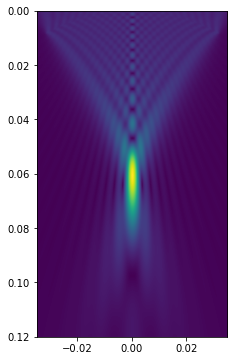

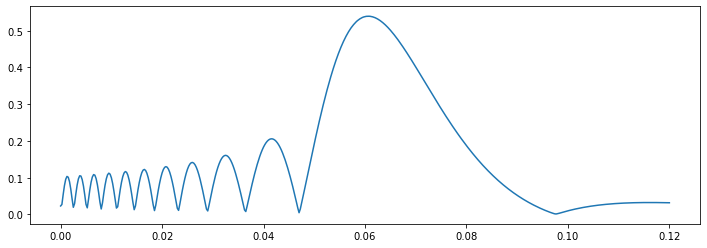

In [13]:
plt.figure(figsize=(12,6))
cy=np.argmin(np.abs(yfield))
plt.imshow(np.abs(u2[:,0,:].T),extent=(yfmin,yfmax,zfmax,zfmin))

plt.figure(figsize=(12,4))
plt.plot(zfield,np.abs(u2[cy,0,:])/1e6)
print(np.abs(u2[:,0,:].T).max()/1e6)
u2.shape[0]*Tx['ds'].size

In [14]:
# grid=pv.StructuredGrid(xp,yp,zp)
# pl = pv.PlotterITK()
# pl.add_mesh(grid,scalars=np.abs(u2.T).flatten())
# pl.add_mesh(mesh,color='r')
# pl.show(True)

You can adjust the view, and should be able to see a plot similar this one
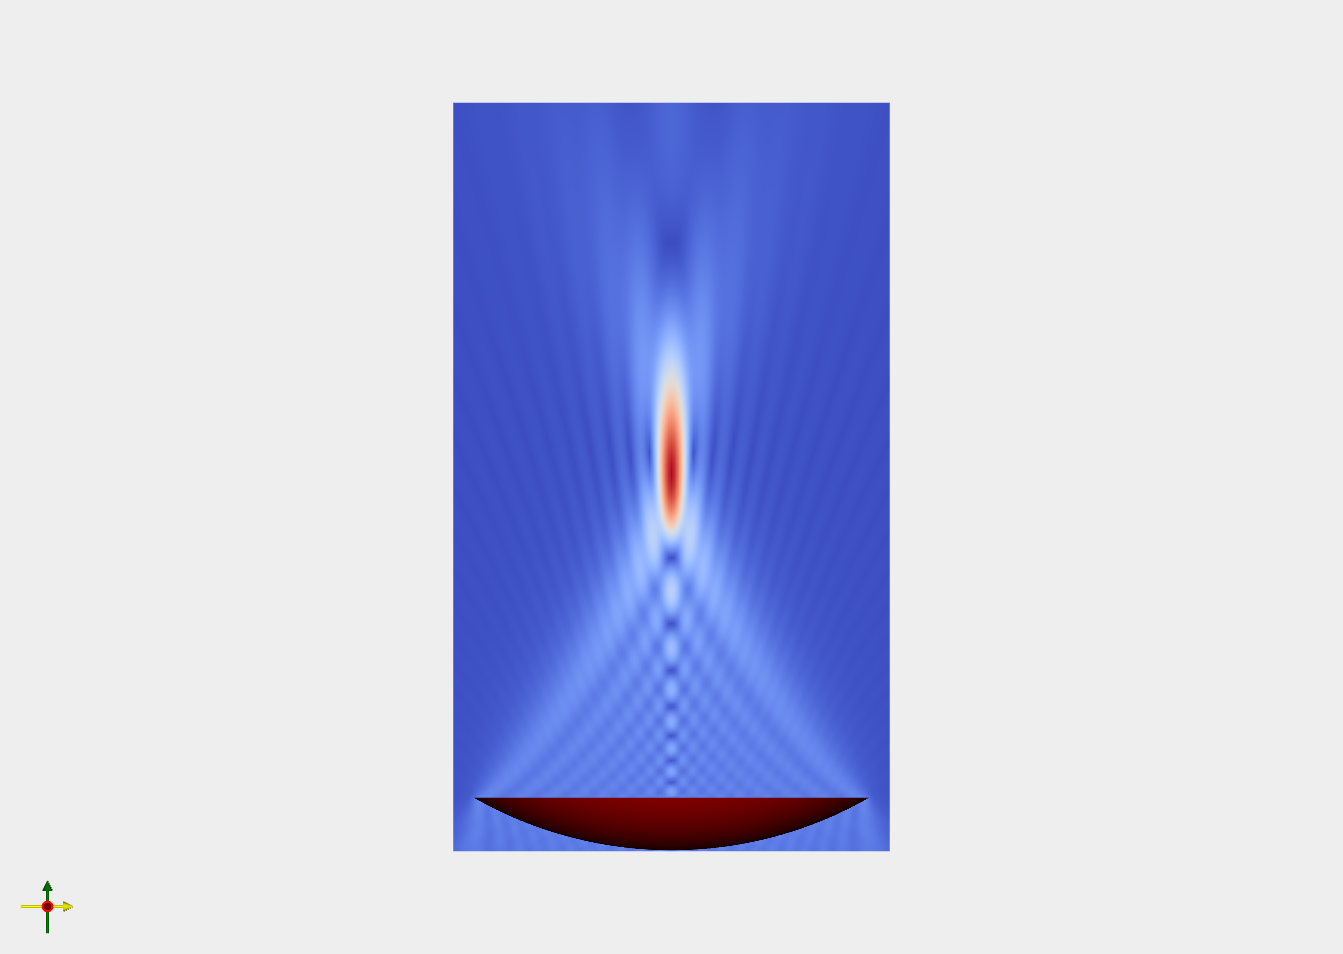

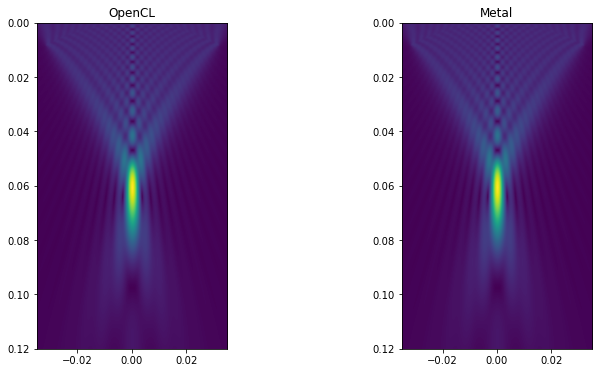

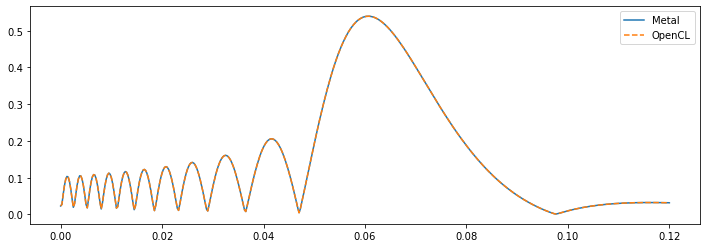

In [15]:
#Some extra testing to evaluate outputs in MacOS from Metal and OpenCL
if platform=='darwin':
    u2o=ForwardSimple(cwvnb_extlay,Tx['center'].astype(np.float32),Tx['ds'].astype(np.float32),u0,rf,MacOsPlatform='OpenCL')
    u2o=np.reshape(u2o,xp.shape)*MediumDensity*MediumSOS #we convert back to Pa
    plt.figure(figsize=(12,6))
    cy=np.argmin(np.abs(yfield))
    
    plt.subplot(1,2,1)
    plt.imshow(np.abs(u2o[:,0,:].T),extent=(yfmin,yfmax,zfmax,zfmin))
    plt.title('OpenCL')
    plt.subplot(1,2,2)
    plt.imshow(np.abs(u2[:,0,:].T),extent=(yfmin,yfmax,zfmax,zfmin))
    plt.title('Metal')
    
    plt.figure(figsize=(12,4))
    plt.plot(zfield,np.abs(u2[cy,0,:])/1e6)
    plt.plot(zfield,np.abs(u2o[cy,0,:])/1e6,'--')
    plt.legend(['Metal','OpenCL'])


In [16]:
%%time
u2=ForwardSimple(cwvnb_extlay,Tx['center'].astype(np.float32),Tx['ds'].astype(np.float32),u0,rf,MacOsPlatform='OpenCL')

CPU times: user 2.52 ms, sys: 3.72 ms, total: 6.24 ms
Wall time: 171 ms
